# Background

- Hypothesis: another explanation for discrepancies is that integrated gradients may flag latent components (which only activate in AND/OR circuits). For example, a later attention head may depend on an earlier one.
- Method: we run activation patching from corrupt to clean, and from clean to corrupt. We also run integrated gradients from corrupt to clean, and from clean to corrupt. AND/OR components will be flagged in integrated gradients in both directions, but only flagged in one direction for patching.
    - Clean→corrupt should pick up OR circuits, Corrupt→clean should pick up AND circuits.
    - AP asymmetry score: difference between AP scores in two directions, normalised by max score.
    - IG asymmetry score: difference between IG scores in two directions, normalised by max score.
    - AND/OR candidates should have low IG asymmetry and high AP asymmetry.

- Implications: if true, we could use IG to detect results which would have required two activation patching passes in different directions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

from utils import Task, TaskDataset, logit_diff_metric, run_from_layer_fn, plot_attn_comparison, plot_correlation
from attribution_methods import integrated_gradients, activation_patching
from captum.attr import LayerIntegratedGradients


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# AND toy model

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple feedforward neural network
class ANDORNet(nn.Module):
    def __init__(self):
        super(ANDORNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)
    
    def run_with_cache(self, x):
        cache = {}

        # Hook function to save output
        def save_activation(name):
            def hook(module, input, output):
                cache[name] = output.detach()
            return hook

        # Register hooks
        handles = []
        for idx, layer in enumerate(self.model):
            handles.append(layer.register_forward_hook(save_activation(f"layer_{idx}")))

        # Run forward pass
        with torch.no_grad():
            output = self.forward(x)

        # Clean up hooks
        for handle in handles:
            handle.remove()

        return output, cache

In [67]:
# Training data for AND logic gate
X = torch.tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

y = torch.tensor([[0.],
                  [0.],
                  [0.],
                  [1.]])


# Initialize the network, loss function and optimizer
and_model = ANDORNet()
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.SGD(and_model.parameters(), lr=0.1)

# Training loop
with torch.enable_grad():
    for epoch in range(1000):
        shuffle_order = torch.randperm(X.size(0))
        shuffled_X = X[shuffle_order]
        shuffled_y = y[shuffle_order]

        optimizer.zero_grad()
        outputs = and_model(shuffled_X)
        loss = criterion(outputs, shuffled_y)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate model
with torch.no_grad():
    preds = and_model(X)
    print("Predictions:")
    print(preds.round())  # Round predictions to get binary output


Epoch 0, Loss: 0.7654
Epoch 100, Loss: 0.5573
Epoch 200, Loss: 0.4172
Epoch 300, Loss: 0.1997
Epoch 400, Loss: 0.0886
Epoch 500, Loss: 0.0475
Epoch 600, Loss: 0.0298
Epoch 700, Loss: 0.0208
Epoch 800, Loss: 0.0156
Epoch 900, Loss: 0.0122
Predictions:
tensor([[0.],
        [0.],
        [0.],
        [1.]])


In [70]:
clean_input = torch.tensor([[1., 1.]], requires_grad=True)
corrupt_input = torch.tensor([[0., 0.]], requires_grad=True)
positive_output, clean_cache = and_model.run_with_cache(clean_input)
negative_output, corrupt_cache = and_model.run_with_cache(corrupt_input)

print(positive_output, clean_cache)
print(negative_output, corrupt_cache)

tensor([[0.9835]]) {'layer_0': tensor([[0.0026, 2.3312]]), 'layer_1': tensor([[0.0026, 2.3312]]), 'layer_2': tensor([[4.0848]]), 'layer_3': tensor([[0.9835]])}
tensor([[5.3869e-05]]) {'layer_0': tensor([[ 2.5488, -1.1855]]), 'layer_1': tensor([[2.5488, 0.0000]]), 'layer_2': tensor([[-9.8289]]), 'layer_3': tensor([[5.3869e-05]])}


In [90]:
ig = LayerIntegratedGradients(and_model, and_model.model[0], multiply_by_inputs=True)
# Patch clean into corrupt
ig_and_attributions = ig.attribute(
    inputs=clean_input, baselines=corrupt_input, internal_batch_size=1
)
print(ig_and_attributions)

# Patch corrupt into clean
ig_and_attributions = ig.attribute(
    inputs=corrupt_input, baselines=clean_input, internal_batch_size=1
)
print(ig_and_attributions)

tensor([[0.4436, 0.5398]])
tensor([[-0.4436, -0.5398]])


In [89]:
def toy_activation_patching(model: nn.Module, baseline_inputs, corrupt_inputs):
    """Attribution scores for neuron A and B in layer 0."""
    n_samples = baseline_inputs.size(0)
    baseline_diff = model(baseline_inputs) - model(corrupt_inputs)
    print(f"Patch {corrupt_inputs} into {baseline_inputs}")

    # Run the model, but patch in the given value at the target layer
    attributions = torch.zeros((n_samples, 2))
    for neuron_idx in range(2):
        # Corrupt specific neuron activations
        corrupted_value = baseline_inputs.clone()
        corrupted_value[:, neuron_idx] = corrupt_inputs[:, neuron_idx]

        patch_diff = model(baseline_inputs) - model(corrupted_value)
        attributions[:, neuron_idx] = patch_diff / baseline_diff
    
    return attributions

with torch.no_grad():
    # Patch clean into corrupt
    ap_and_clean_corrupt = toy_activation_patching(and_model, corrupt_input, clean_input)
    print(f"Clean->Corrupt: {ap_and_clean_corrupt}\n")
    # Patch corrupt into clean
    ap_and_corrupt_clean = toy_activation_patching(and_model, clean_input, corrupt_input)
    print("Corrupt->Clean", ap_and_corrupt_clean)

Patch tensor([[1., 1.]], requires_grad=True) into tensor([[0., 0.]], requires_grad=True)
Clean->Corrupt: tensor([[0.0117, 0.0116]])

Patch tensor([[0., 0.]], requires_grad=True) into tensor([[1., 1.]], requires_grad=True)
Corrupt->Clean tensor([[0.9884, 0.9883]])


In the example of the AND toy model, we can see that:

- IG attributes roughly even importance (0.5) to neurons A and B. This is correct and holds for gradients in both directions (order of clean/corrupt as input/baseline only affects sign).
- Activation patching from clean ([1, 1]) to corrupt ([0, 0]) suggests that both A and B have low attribution scores, because patching either A or B does not affect the output. Denoising fails to identify the circuit components.
- Activation patching from corrupt ([0, 0]) to clean ([1, 1]) suggests that both A and B have high attribution scores, because patching either A or B affects the output.

Therefore, IG correctly identifies AND circuit components, but AP only detects AND circuit components when patching from corrupt to clean.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Training data for OR logic gate
X = torch.tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

y = torch.tensor([[0.],
                  [1.],
                  [1.],
                  [1.]])

# Initialize the model, loss function, and optimizer
or_model = ANDORNet()
criterion = nn.BCELoss()
optimizer = optim.SGD(or_model.parameters(), lr=0.1)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = or_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate
with torch.no_grad():
    preds = or_model(X)
    print("Predictions:")
    print(preds.round())


# AND/OR circuits in GPT2-small

In [3]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


In [5]:
# Patch from clean to corrupt

ig_clean_corrupt_mlp, ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)
ap_clean_corrupt_mlp, ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-1.4020e-06,  4.9733e-07,  1.5763e-06, -1.4198e-06,  4.1211e-07,
        -2.5690e-05,  2.8592e-07,  6.0722e-07,  1.3560e-05,  2.9227e-06],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-2.5807e-06, -1.2219e-06, -4.9546e-07, -7.9628e-07,  8.7917e-07,
        -2.3365e-05, -5.2527e-07,  1.2442e-06,  1.6928e-05,  3.0734e-07],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-6.7381e-07, -1.3532e-06, -7.0618e-07,  3.7951e-07, -3.1944e-06,
        -2.9422e-05, -4.0187e-07,  1.3728e-06,  1.1683e-05, -4.5705e-07],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-1.3824e-06, -2.1905e-06, -1.1295e-06, -9.3598e-07,  3.1888e-06,
        -1.0759e-05,  9.0152e-07,  2.5430e-06,  6.3032e-06,  4.2841e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [ ]:
torch.save(ig_clean_corrupt_mlp, "saved_results/ig_clean_corrupt_mlp.pt")
torch.save(ig_clean_corrupt_attn, "saved_results/ig_clean_corrupt_attn.pt")
torch.save(ap_clean_corrupt_mlp, "saved_results/ap_clean_corrupt_mlp.pt")
torch.save(ap_clean_corrupt_attn, "saved_results/ap_clean_corrupt_attn.pt")

In [6]:
# Patch from corrupt to clean

ig_corrupt_clean_mlp, ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)
ap_corrupt_clean_mlp, ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_cache, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.8906e-07, -2.9011e-07,  8.9733e-07, -8.2795e-07, -1.2587e-06,
        -2.0266e-06, -3.3854e-07,  5.1875e-07, -1.4976e-06,  6.5146e-07],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-1.3113e-06, -1.7695e-07, -5.3085e-07, -3.6415e-06,  2.6822e-07,
        -4.7684e-06, -3.5390e-07, -1.1399e-06,  4.7684e-06, -1.7341e-06],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 8.1258e-08, -1.3346e-06,  1.1593e-06,  3.9861e-07, -2.5816e-06,
         3.5120e-06, -2.3097e-07, -8.7428e-07,  4.7833e-06,  7.4506e-09],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-9.4093e-07,  1.0189e-06,  3.6601e-07, -7.4413e-07,  1.9632e-06,
         7.9051e-06, -2.4661e-06,  1.3015e-07,  5.9232e-06, -1.2573e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [ ]:
torch.save(ig_corrupt_clean_mlp, "saved_results/ig_corrupt_clean_mlp.pt")
torch.save(ig_corrupt_clean_attn, "saved_results/ig_corrupt_clean_attn.pt")
torch.save(ap_corrupt_clean_mlp, "saved_results/ap_corrupt_clean_mlp.pt")
torch.save(ap_corrupt_clean_attn, "saved_results/ap_corrupt_clean_attn.pt")

In [10]:
ig_corrupt_clean_mlp = torch.load("saved_results/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("saved_results/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("saved_results/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("saved_results/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("saved_results/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("saved_results/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("saved_results/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("saved_results/ap_clean_corrupt_attn.pt")


In [21]:
def asymmetry_score(corrupt_clean: torch.Tensor, clean_corrupt: torch.Tensor, is_ig: bool):
    assert corrupt_clean.shape == clean_corrupt.shape, \
        f"Cannot calculate asymmetry between matrices of different shapes, {corrupt_clean.shape} and {clean_corrupt.shape}"
    max_score = max(corrupt_clean.max(), clean_corrupt.max())
    if is_ig:
        # Expect opposite directions to cancel out attribution scores
        return (corrupt_clean + clean_corrupt).abs() / max_score
    return (corrupt_clean - clean_corrupt).abs() / max_score

ig_mlp_asymmetry = asymmetry_score(ig_corrupt_clean_mlp, ig_clean_corrupt_mlp, is_ig=True)
ig_attn_asymmetry = asymmetry_score(ig_corrupt_clean_attn, ig_clean_corrupt_attn, is_ig=True)

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

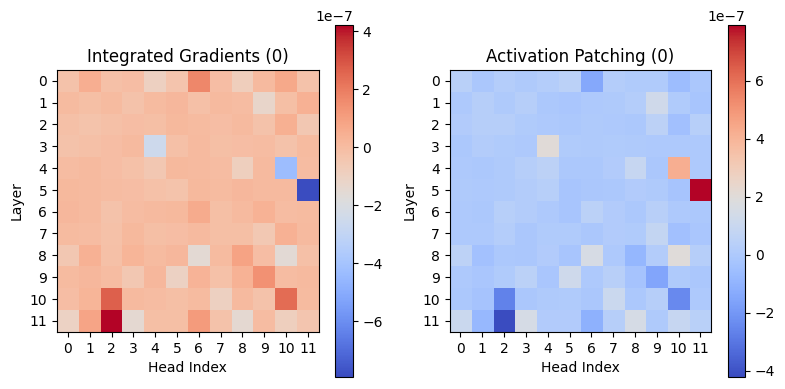

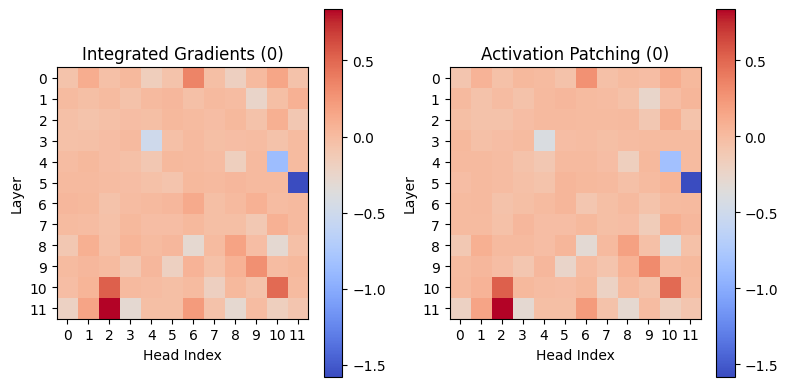

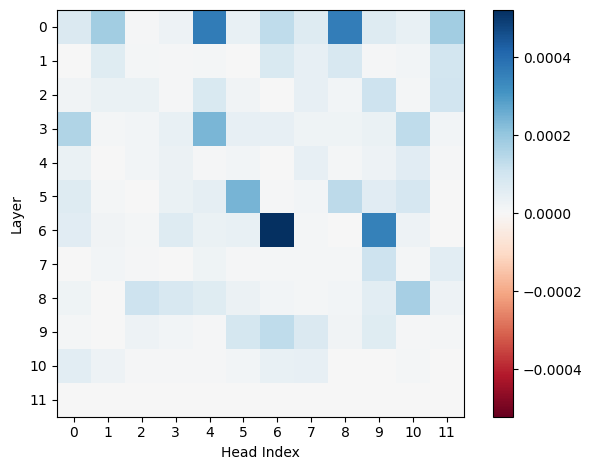

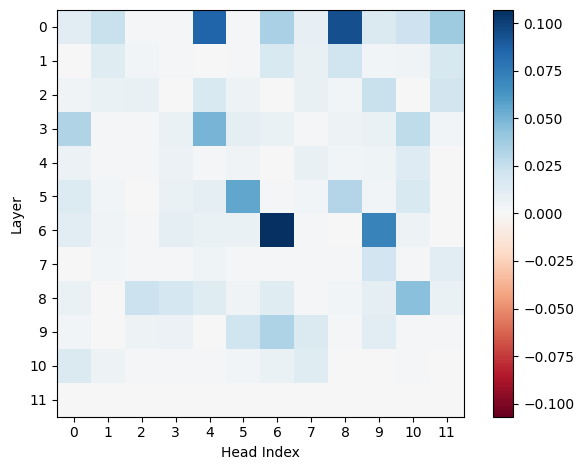

In [33]:
from utils import plot_attn

plot_attn_comparison(ig_clean_corrupt_attn[0].unsqueeze(0), ig_corrupt_clean_attn[0].unsqueeze(0), Task.IOI, model)
plot_attn_comparison(ap_clean_corrupt_attn[0].unsqueeze(0), ap_corrupt_clean_attn[0].unsqueeze(0), Task.IOI, model)

plot_attn(ig_attn_asymmetry[0], model)
plot_attn(ap_attn_asymmetry[0], model)

torch.Size([10, 12, 12])
torch.Size([10, 12, 12])
tensor([[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0

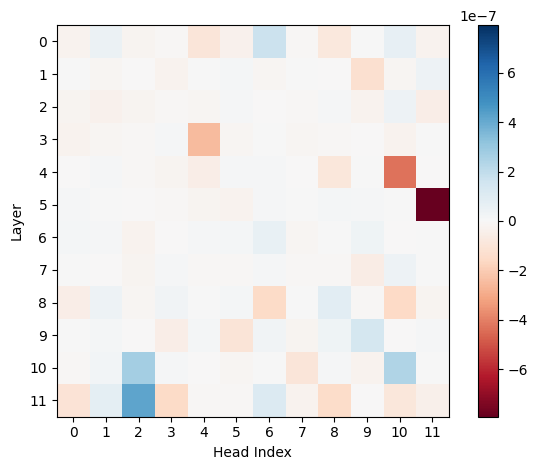

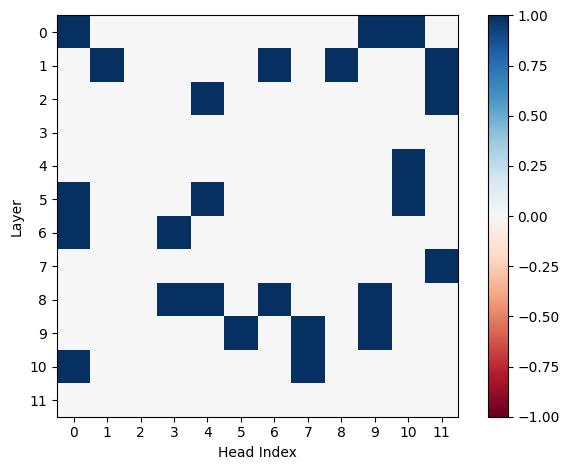

In [56]:
gt_mask = (ap_attn_asymmetry > ig_attn_asymmetry + 1e-2)
zero_mask = torch.isclose(ig_attn_asymmetry, torch.zeros_like(ig_attn_asymmetry), atol=1e-4)
print(gt_mask.shape)
print(zero_mask.shape)

print(gt_mask[0].int())

mask = gt_mask & zero_mask
print(mask[0].int())

plot_attn(ig_clean_corrupt_attn[0], model)
plot_attn(mask[0].int(), model)
